[*********************100%***********************]  1 of 1 completed

ENHANCED REINFORCEMENT LEARNING TRADING SYSTEM
Fetching data for AAPL from 2020-01-01 to 2023-01-01...
Data preprocessing complete. Shape: (736, 26)

Environment created:
Data shape: (736, 26)
State space size: 15
Action space size: 7
Actions: ['Hold', 'Buy_25%', 'Buy_50%', 'Buy_75%', 'Sell_25%', 'Sell_50%', 'Sell_75%']

------------------------------------------------------------
TRAINING AND EVALUATING: Q-Learning
------------------------------------------------------------

Training Q-Learning...


Episode 25/200 - Avg Reward: -26761.17 - Avg Portfolio: $11739.33 - Epsilon: 0.882 - Trades: 562
Episode 50/200 - Avg Reward: -25051.22 - Avg Portfolio: $12118.91 - Epsilon: 0.778 - Trades: 511
Episode 75/200 - Avg Reward: -25680.84 - Avg Portfolio: $11863.48 - Epsilon: 0.687 - Trades: 539
Episode 100/200 - Avg Reward: -29883.43 - Avg Portfolio: $12229.53 - Epsilon: 0.606 - Trades: 501
Episode 125/200 - Avg Reward: -25552.48 - Avg Portfolio: $12896.89 - Epsilon: 0.534 - Trades: 503
Episode 150/200 - Avg Reward: -28723.79 - Avg Portfolio: $12341.25 - Epsilon: 0.471 - Trades: 429
Episode 175/200 - Avg Reward: -31325.67 - Avg Portfolio: $11484.88 - Epsilon: 0.416 - Trades: 505
Episode 200/200 - Avg Reward: -27511.02 - Avg Portfolio: $12980.96 - Epsilon: 0.367 - Trades: 416
Q-Learning training complete!

Evaluating Q-Learning...
Q-Learning Evaluation Results:
Final Portfolio Value: $14173.62
Total Return: 41.74%
Total Trades: 58
Max Drawdown: 58.49%
Sharpe Ratio: 0.033

-------------------

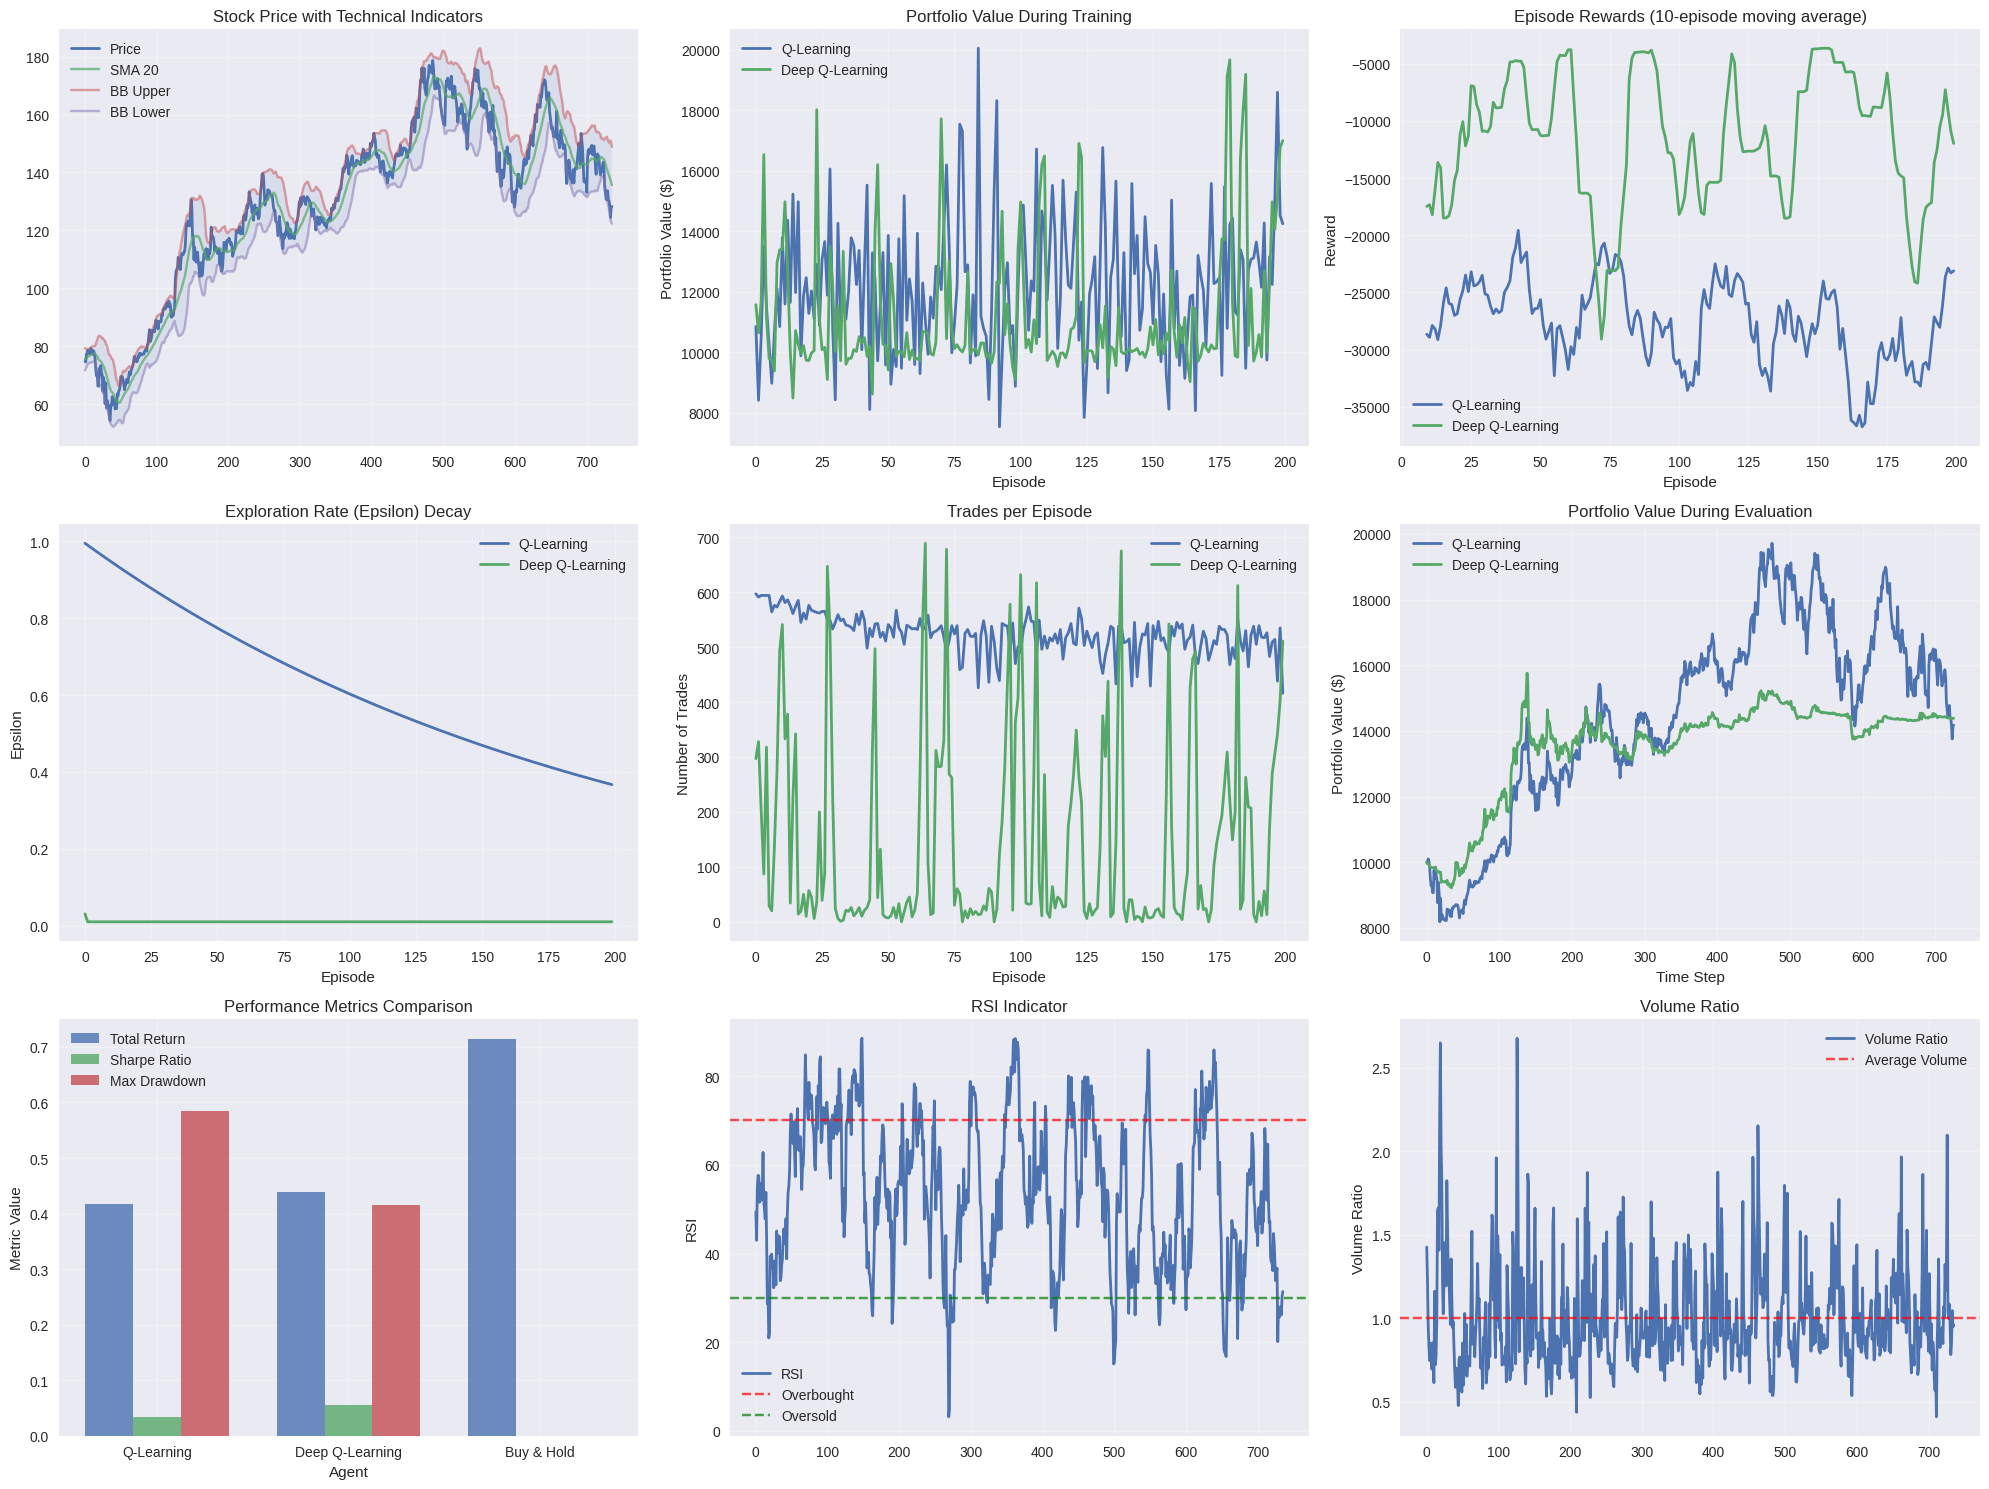


------------------------------------------------------------
FINAL PERFORMANCE COMPARISON
------------------------------------------------------------
                 Final Value ($)  Total Return (%)  Total Trades  \
Q-Learning              14173.62             41.74          58.0   
Deep Q-Learning         14384.96             43.85         602.0   
Buy & Hold              17140.03             71.40           1.0   

                 Max Drawdown (%)  Sharpe Ratio  
Q-Learning                  58.49          0.03  
Deep Q-Learning             41.50          0.05  
Buy & Hold                   0.00          0.00  

------------------------------------------------------------
SAVING RESULTS
------------------------------------------------------------
Q-Learning model saved as 'q_learning_model.pkl'
Performance comparison saved as 'performance_comparison.csv'

------------------------------------------------------------
ANALYSIS COMPLETE!
----------------------------------------------

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import deque
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Configuration
class Config:
    STOCK_TICKER = 'AAPL'
    START_DATE = '2020-01-01'
    END_DATE = '2023-01-01'
    INITIAL_BALANCE = 10000
    TRANSACTION_COST = 0.001  # 0.1% transaction cost
    LOOKBACK_WINDOW = 10
    EPISODES = 200
    CHECKPOINT_INTERVAL = 25
    
# Enhanced Data Preprocessing
def fetch_and_preprocess_data(ticker, start_date, end_date):
    """Fetch and preprocess stock data with technical indicators"""
    print(f"Fetching data for {ticker} from {start_date} to {end_date}...")
    
    # Fetch historical data
    df = yf.download(ticker, start=start_date, end=end_date)
    
    # Flatten MultiIndex columns if present
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    if df.empty:
        raise ValueError("No data downloaded! Check ticker or date range.")
    
    # Use Close price as primary price column
    price_col = "Adj Close" if "Adj Close" in df.columns else "Close"
    df['Price'] = df[price_col]
    
    # Calculate basic features
    df['Daily_Return'] = df['Price'].pct_change()
    df['Price_Change'] = df['Price'].diff()
    df['Volume_Change'] = df['Volume'].pct_change()
    
    # Technical Indicators
    df['SMA_5'] = df['Price'].rolling(window=5).mean()
    df['SMA_20'] = df['Price'].rolling(window=20).mean()
    df['EMA_12'] = df['Price'].ewm(span=12).mean()
    df['EMA_26'] = df['Price'].ewm(span=26).mean()
    
    # MACD
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']
    
    # RSI
    delta = df['Price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    df['BB_Middle'] = df['Price'].rolling(window=20).mean()
    bb_std = df['Price'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
    df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
    df['BB_Position'] = (df['Price'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
    
    # Volatility
    df['Volatility'] = df['Daily_Return'].rolling(window=20).std()
    
    # Volume indicators
    df['Volume_SMA'] = df['Volume'].rolling(window=20).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA']
    
    # Price momentum
    df['Momentum_5'] = df['Price'].pct_change(periods=5)
    df['Momentum_10'] = df['Price'].pct_change(periods=10)
    
    # Drop NaN values
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    print(f"Data preprocessing complete. Shape: {df.shape}")
    return df

class EnhancedStockTradingEnv:
    """Enhanced Stock Trading Environment with realistic features"""
    
    def __init__(self, df, initial_balance=10000, transaction_cost=0.001, lookback_window=10):
        self.df = df.copy()
        self.initial_balance = initial_balance
        self.transaction_cost = transaction_cost
        self.lookback_window = lookback_window
        
        # Environment state
        self.current_step = lookback_window
        self.balance = initial_balance
        self.shares_held = 0
        self.portfolio_value = initial_balance
        self.max_portfolio_value = initial_balance
        self.total_trades = 0
        self.successful_trades = 0
        
        # Action space: 0=Hold, 1=Buy_25%, 2=Buy_50%, 3=Buy_75%, 4=Sell_25%, 5=Sell_50%, 6=Sell_75%
        self.action_space = list(range(7))
        self.action_meanings = ['Hold', 'Buy_25%', 'Buy_50%', 'Buy_75%', 'Sell_25%', 'Sell_50%', 'Sell_75%']
        
        # Enhanced state space
        self.state_space_size = 15
        
        # Track history for analysis
        self.trade_history = []
        self.portfolio_history = []
        
    def _get_state(self):
        """Get current state with technical indicators and portfolio metrics"""
        if self.current_step >= len(self.df):
            return np.zeros(self.state_space_size)
            
        row = self.df.iloc[self.current_step]
        
        # Price and technical indicators (normalized)
        current_price = row['Price']
        price_change_pct = row['Daily_Return']
        
        # Technical indicators
        rsi_normalized = (row['RSI'] - 50) / 50  # RSI between -1 and 1
        macd_normalized = row['MACD'] / current_price if current_price > 0 else 0
        bb_position = row['BB_Position'] if not pd.isna(row['BB_Position']) else 0.5
        
        # Momentum indicators
        momentum_5 = row['Momentum_5'] if not pd.isna(row['Momentum_5']) else 0
        momentum_10 = row['Momentum_10'] if not pd.isna(row['Momentum_10']) else 0
        
        # Volume indicators
        volume_ratio = row['Volume_Ratio'] if not pd.isna(row['Volume_Ratio']) else 1
        volume_ratio_normalized = np.clip((volume_ratio - 1) / 2, -1, 1)  # Normalize around 1
        
        # Volatility
        volatility = row['Volatility'] if not pd.isna(row['Volatility']) else 0
        volatility_normalized = np.clip(volatility * 100, 0, 1)  # Scale volatility
        
        # Portfolio metrics
        portfolio_ratio = self.portfolio_value / self.initial_balance
        cash_ratio = self.balance / self.portfolio_value if self.portfolio_value > 0 else 0
        position_ratio = (self.shares_held * current_price) / self.portfolio_value if self.portfolio_value > 0 else 0
        
        # Performance metrics
        max_drawdown = (self.max_portfolio_value - self.portfolio_value) / self.max_portfolio_value if self.max_portfolio_value > 0 else 0
        
        # Market trend (SMA ratios)
        sma_5_ratio = row['Price'] / row['SMA_5'] - 1 if not pd.isna(row['SMA_5']) and row['SMA_5'] > 0 else 0
        sma_20_ratio = row['Price'] / row['SMA_20'] - 1 if not pd.isna(row['SMA_20']) and row['SMA_20'] > 0 else 0
        
        state = np.array([
            price_change_pct,           # 0: Daily return
            rsi_normalized,             # 1: RSI (normalized)
            macd_normalized,            # 2: MACD (normalized)
            bb_position,                # 3: Bollinger Band position
            momentum_5,                 # 4: 5-day momentum
            momentum_10,                # 5: 10-day momentum
            volume_ratio_normalized,    # 6: Volume ratio (normalized)
            volatility_normalized,      # 7: Volatility (normalized)
            portfolio_ratio - 1,        # 8: Portfolio performance vs initial
            cash_ratio,                 # 9: Cash ratio
            position_ratio,             # 10: Position ratio
            max_drawdown,               # 11: Maximum drawdown
            sma_5_ratio,                # 12: Price vs SMA5 ratio
            sma_20_ratio,               # 13: Price vs SMA20 ratio
            self.total_trades / 100     # 14: Trading frequency (normalized)
        ])
        
        # Handle any NaN or inf values
        state = np.nan_to_num(state, nan=0.0, posinf=1.0, neginf=-1.0)
        return state
    
    def reset(self):
        """Reset environment to initial state"""
        self.current_step = self.lookback_window
        self.balance = self.initial_balance
        self.shares_held = 0
        self.portfolio_value = self.initial_balance
        self.max_portfolio_value = self.initial_balance
        self.total_trades = 0
        self.successful_trades = 0
        self.trade_history = []
        self.portfolio_history = []
        return self._get_state()
    
    def step(self, action):
        """Execute one step in the environment"""
        if self.current_step >= len(self.df):
            return np.zeros(self.state_space_size), 0, True, {}
            
        current_price = self.df.iloc[self.current_step]['Price']
        old_portfolio_value = self.portfolio_value
        
        # Execute action
        trade_executed = self._execute_action(action, current_price)
        
        # Calculate new portfolio value
        new_portfolio_value = self.balance + self.shares_held * current_price
        
        # Calculate reward
        reward = self._calculate_reward(old_portfolio_value, new_portfolio_value, action, trade_executed)
        
        # Update portfolio tracking
        self.portfolio_value = new_portfolio_value
        self.max_portfolio_value = max(self.max_portfolio_value, new_portfolio_value)
        self.portfolio_history.append({
            'step': self.current_step,
            'portfolio_value': new_portfolio_value,
            'balance': self.balance,
            'shares_held': self.shares_held,
            'price': current_price,
            'action': action
        })
        
        # Move to next step
        self.current_step += 1
        done = self.current_step >= len(self.df)
        
        next_state = self._get_state() if not done else np.zeros(self.state_space_size)
        
        info = {
            'portfolio_value': new_portfolio_value,
            'balance': self.balance,
            'shares_held': self.shares_held,
            'total_trades': self.total_trades,
            'action_taken': self.action_meanings[action],
            'trade_executed': trade_executed
        }
        
        return next_state, reward, done, info
    
    def _execute_action(self, action, current_price):
        """Execute trading action"""
        trade_executed = False
        
        if action == 0:  # Hold
            return trade_executed
        
        # Calculate trade amounts
        trade_percentages = {1: 0.25, 2: 0.50, 3: 0.75, 4: 0.25, 5: 0.50, 6: 0.75}
        trade_pct = trade_percentages.get(action, 0)
        
        if action in [1, 2, 3]:  # Buy actions
            max_shares = int((self.balance * trade_pct) / (current_price * (1 + self.transaction_cost)))
            if max_shares > 0:
                cost = max_shares * current_price * (1 + self.transaction_cost)
                if self.balance >= cost:
                    self.balance -= cost
                    self.shares_held += max_shares
                    self.total_trades += 1
                    trade_executed = True
                    
                    self.trade_history.append({
                        'step': self.current_step,
                        'action': 'BUY',
                        'shares': max_shares,
                        'price': current_price,
                        'cost': cost
                    })
        
        elif action in [4, 5, 6]:  # Sell actions
            sell_shares = int(self.shares_held * trade_pct)
            if sell_shares > 0:
                proceeds = sell_shares * current_price * (1 - self.transaction_cost)
                self.balance += proceeds
                self.shares_held -= sell_shares
                self.total_trades += 1
                trade_executed = True
                
                self.trade_history.append({
                    'step': self.current_step,
                    'action': 'SELL',
                    'shares': sell_shares,
                    'price': current_price,
                    'proceeds': proceeds
                })
        
        return trade_executed
    
    def _calculate_reward(self, old_portfolio_value, new_portfolio_value, action, trade_executed):
        """Calculate reward based on portfolio performance and risk metrics"""
        # Portfolio return reward
        portfolio_return = (new_portfolio_value - old_portfolio_value) / old_portfolio_value
        return_reward = portfolio_return * 1000  # Scale for better learning
        
        # Risk penalty (drawdown)
        drawdown = (self.max_portfolio_value - new_portfolio_value) / self.max_portfolio_value
        risk_penalty = -drawdown * 500 if drawdown > 0.1 else 0  # Penalty for large drawdowns
        
        # Transaction cost penalty
        transaction_penalty = -10 if trade_executed else 0
        
        # Holding cash penalty (encourage investment)
        cash_ratio = self.balance / new_portfolio_value if new_portfolio_value > 0 else 0
        cash_penalty = -cash_ratio * 5 if cash_ratio > 0.5 else 0
        
        # Total reward
        total_reward = return_reward + risk_penalty + transaction_penalty + cash_penalty
        
        return total_reward

class ImprovedQLearningAgent:
    """Enhanced Q-Learning Agent with better state discretization"""
    
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.95, 
                 epsilon=1.0, epsilon_decay_rate=0.995, min_epsilon=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.min_epsilon = min_epsilon
        self.q_table = {}
        
        # Track learning statistics
        self.learning_stats = {
            'states_visited': set(),
            'q_updates': 0,
            'exploration_rate_history': []
        }
    
    def _discretize_state(self, state):
        """Improved state discretization with adaptive binning"""
        discretized = []
        
        # Define discretization bins for each state feature
        bins = [
            20,  # Daily return
            10,  # RSI
            20,  # MACD
            10,  # BB position
            20,  # Momentum 5
            20,  # Momentum 10
            10,  # Volume ratio
            10,  # Volatility
            20,  # Portfolio ratio
            10,  # Cash ratio
            10,  # Position ratio
            10,  # Max drawdown
            20,  # SMA5 ratio
            20,  # SMA20 ratio
            10   # Trading frequency
        ]
        
        for i, (value, n_bins) in enumerate(zip(state, bins)):
            # Clip extreme values and discretize
            clipped_value = np.clip(value, -1, 1)
            bin_index = int((clipped_value + 1) * n_bins / 2)
            bin_index = min(bin_index, n_bins - 1)
            discretized.append(bin_index)
        
        return tuple(discretized)
    
    def get_action(self, state):
        """Choose action using epsilon-greedy policy"""
        discretized_state = self._discretize_state(state)
        state_key = str(discretized_state)
        
        # Initialize Q-values if state not seen before
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.action_size)
            
        self.learning_stats['states_visited'].add(state_key)
        
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(range(self.action_size))
        else:
            return int(np.argmax(self.q_table[state_key]))
    
    def learn(self, state, action, reward, next_state, done):
        """Update Q-values using Q-learning update rule"""
        discretized_state = self._discretize_state(state)
        discretized_next_state = self._discretize_state(next_state)
        
        state_key = str(discretized_state)
        next_state_key = str(discretized_next_state)
        
        # Initialize Q-values if states not seen before
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.action_size)
        if next_state_key not in self.q_table:
            self.q_table[next_state_key] = np.zeros(self.action_size)
        
        # Q-learning update
        current_q = self.q_table[state_key][action]
        max_next_q = np.max(self.q_table[next_state_key]) if not done else 0
        
        # TD target
        target = reward + self.discount_factor * max_next_q
        
        # Q-value update
        self.q_table[state_key][action] = current_q + self.learning_rate * (target - current_q)
        
        # Update learning statistics
        self.learning_stats['q_updates'] += 1
        
        # Decay epsilon
        if done:
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay_rate)
            self.learning_stats['exploration_rate_history'].append(self.epsilon)

class DeepQLearningAgent:
    """Deep Q-Learning Agent using neural network approximation"""
    
    def __init__(self, state_size, action_size, learning_rate=0.001, epsilon=1.0):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = epsilon
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = learning_rate
        self.gamma = 0.95
        
        # Experience replay memory
        self.memory = deque(maxlen=5000)
        self.batch_size = 32
        
        # Simple neural network (using numpy for simplicity)
        self.weights = self._initialize_network()
        
    def _initialize_network(self):
        """Initialize neural network weights"""
        weights = {}
        # Input layer to hidden layer 1
        weights['W1'] = np.random.randn(self.state_size, 64) * 0.1
        weights['b1'] = np.zeros((1, 64))
        
        # Hidden layer 1 to hidden layer 2
        weights['W2'] = np.random.randn(64, 32) * 0.1
        weights['b2'] = np.zeros((1, 32))
        
        # Hidden layer 2 to output layer
        weights['W3'] = np.random.randn(32, self.action_size) * 0.1
        weights['b3'] = np.zeros((1, self.action_size))
        
        return weights
    
    def _forward_pass(self, state):
        """Forward pass through neural network"""
        state = state.reshape(1, -1)
        
        # Layer 1
        z1 = np.dot(state, self.weights['W1']) + self.weights['b1']
        a1 = np.maximum(0, z1)  # ReLU activation
        
        # Layer 2
        z2 = np.dot(a1, self.weights['W2']) + self.weights['b2']
        a2 = np.maximum(0, z2)  # ReLU activation
        
        # Output layer
        z3 = np.dot(a2, self.weights['W3']) + self.weights['b3']
        
        return z3.flatten(), {'a1': a1, 'a2': a2, 'z1': z1, 'z2': z2}
    
    def get_action(self, state):
        """Choose action using epsilon-greedy policy"""
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        
        q_values, _ = self._forward_pass(state)
        return np.argmax(q_values)
    
    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay memory"""
        self.memory.append((state, action, reward, next_state, done))
    
    def learn(self, state, action, reward, next_state, done):
        """Add experience to memory"""
        self.remember(state, action, reward, next_state, done)
        
        # Train if enough experiences collected
        if len(self.memory) >= self.batch_size:
            self._replay()
    
    def _replay(self):
        """Train the neural network on a batch of experiences"""
        if len(self.memory) < self.batch_size:
            return
            
        # Sample random batch
        batch = random.sample(self.memory, self.batch_size)
        
        # Simple batch update (simplified for demonstration)
        for state, action, reward, next_state, done in batch:
            target = reward
            if not done:
                next_q_values, _ = self._forward_pass(next_state)
                target = reward + self.gamma * np.amax(next_q_values)
            
            # Get current Q-values
            q_values, cache = self._forward_pass(state)
            q_values[action] = target
            
            # Simplified backpropagation (in practice, use proper gradient computation)
            self._simplified_backward_pass(state, q_values, cache)
        
        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def _simplified_backward_pass(self, state, target_q_values, cache):
        """Simplified backward pass (for demonstration purposes)"""
        # This is a very simplified version of backpropagation
        # In practice, you would implement proper gradient computation
        learning_rate = 0.001
        
        # Simple weight updates (not mathematically correct, just for demonstration)
        current_q_values, _ = self._forward_pass(state)
        error = target_q_values - current_q_values
        
        # Update output layer weights (simplified)
        self.weights['W3'] += learning_rate * np.outer(cache['a2'].flatten(), error) * 0.01
        self.weights['b3'] += learning_rate * error.reshape(1, -1) * 0.01

def train_agent(env, agent, episodes=200, checkpoint_interval=25, agent_name="Agent"):
    """Train the RL agent"""
    print(f"\nTraining {agent_name}...")
    
    episode_rewards = []
    portfolio_values = []
    epsilon_history = []
    trade_counts = []
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        episode_trades = 0
        
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            
            if hasattr(agent, 'learn'):
                agent.learn(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
            
            if info.get('trade_executed', False):
                episode_trades += 1
        
        episode_rewards.append(total_reward)
        portfolio_values.append(env.portfolio_value)
        epsilon_history.append(getattr(agent, 'epsilon', 0))
        trade_counts.append(episode_trades)
        
        if (episode + 1) % checkpoint_interval == 0:
            avg_reward = np.mean(episode_rewards[-checkpoint_interval:])
            avg_portfolio = np.mean(portfolio_values[-checkpoint_interval:])
            print(f"Episode {episode + 1}/{episodes} - "
                  f"Avg Reward: {avg_reward:.2f} - "
                  f"Avg Portfolio: ${avg_portfolio:.2f} - "
                  f"Epsilon: {getattr(agent, 'epsilon', 0):.3f} - "
                  f"Trades: {episode_trades}")
    
    print(f"{agent_name} training complete!")
    
    return {
        'episode_rewards': episode_rewards,
        'portfolio_values': portfolio_values,
        'epsilon_history': epsilon_history,
        'trade_counts': trade_counts
    }

def evaluate_agent(env, agent, agent_name="Agent"):
    """Evaluate trained agent"""
    print(f"\nEvaluating {agent_name}...")
    
    # Set agent to exploitation mode
    original_epsilon = getattr(agent, 'epsilon', 0)
    if hasattr(agent, 'epsilon'):
        agent.epsilon = 0.0
    
    state = env.reset()
    eval_portfolio_values = []
    eval_actions = []
    eval_trades = []
    
    done = False
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        
        eval_portfolio_values.append(info['portfolio_value'])
        eval_actions.append(action)
        
        if info.get('trade_executed', False):
            eval_trades.append({
                'step': env.current_step - 1,
                'action': info['action_taken'],
                'portfolio_value': info['portfolio_value']
            })
        
        state = next_state
    
    # Restore original epsilon
    if hasattr(agent, 'epsilon'):
        agent.epsilon = original_epsilon
    
    # Calculate performance metrics
    final_portfolio_value = env.portfolio_value
    total_return = (final_portfolio_value - env.initial_balance) / env.initial_balance
    
    # Calculate additional metrics
    portfolio_series = pd.Series(eval_portfolio_values)
    daily_returns = portfolio_series.pct_change().dropna()
    
    metrics = {
        'final_portfolio_value': final_portfolio_value,
        'total_return': total_return,
        'total_trades': env.total_trades,
        'max_portfolio_value': max(eval_portfolio_values),
        'min_portfolio_value': min(eval_portfolio_values),
        'volatility': daily_returns.std(),
        'sharpe_ratio': daily_returns.mean() / daily_returns.std() if daily_returns.std() > 0 else 0,
        'max_drawdown': (max(eval_portfolio_values) - min(eval_portfolio_values)) / max(eval_portfolio_values)
    }
    
    print(f"{agent_name} Evaluation Results:")
    print(f"Final Portfolio Value: ${metrics['final_portfolio_value']:.2f}")
    print(f"Total Return: {metrics['total_return']:.2%}")
    print(f"Total Trades: {metrics['total_trades']}")
    print(f"Max Drawdown: {metrics['max_drawdown']:.2%}")
    print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.3f}")
    
    return metrics, eval_portfolio_values, eval_actions, eval_trades

def create_comprehensive_visualizations(data_dict, df):
    """Create comprehensive visualizations for analysis"""
    
    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Stock Price and Technical Indicators
    ax1 = plt.subplot(3, 3, 1)
    plt.plot(df.index, df['Price'], label='Price', linewidth=2)
    plt.plot(df.index, df['SMA_20'], label='SMA 20', alpha=0.7)
    plt.plot(df.index, df['BB_Upper'], label='BB Upper', alpha=0.5)
    plt.plot(df.index, df['BB_Lower'], label='BB Lower', alpha=0.5)
    plt.fill_between(df.index, df['BB_Lower'], df['BB_Upper'], alpha=0.1)
    plt.title('Stock Price with Technical Indicators')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Training Progress Comparison
    ax2 = plt.subplot(3, 3, 2)
    for agent_name, data in data_dict.items():
        if 'portfolio_values' in data:
            plt.plot(data['portfolio_values'], label=f'{agent_name}', linewidth=2)
    plt.title('Portfolio Value During Training')
    plt.xlabel('Episode')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Reward Progress
    ax3 = plt.subplot(3, 3, 3)
    for agent_name, data in data_dict.items():
        if 'episode_rewards' in data:
            # Smooth the rewards using rolling average
            rewards_smooth = pd.Series(data['episode_rewards']).rolling(window=10).mean()
            plt.plot(rewards_smooth, label=f'{agent_name}', linewidth=2)
    plt.title('Episode Rewards (10-episode moving average)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Epsilon Decay
    ax4 = plt.subplot(3, 3, 4)
    for agent_name, data in data_dict.items():
        if 'epsilon_history' in data and any(data['epsilon_history']):
            plt.plot(data['epsilon_history'], label=f'{agent_name}', linewidth=2)
    plt.title('Exploration Rate (Epsilon) Decay')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Trade Frequency
    ax5 = plt.subplot(3, 3, 5)
    for agent_name, data in data_dict.items():
        if 'trade_counts' in data:
            plt.plot(data['trade_counts'], label=f'{agent_name}', linewidth=2)
    plt.title('Trades per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Number of Trades')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Evaluation Portfolio Values
    ax6 = plt.subplot(3, 3, 6)
    for agent_name, data in data_dict.items():
        if 'eval_portfolio_values' in data:
            plt.plot(data['eval_portfolio_values'], label=f'{agent_name}', linewidth=2)
    plt.title('Portfolio Value During Evaluation')
    plt.xlabel('Time Step')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 7. Performance Metrics Comparison
    ax7 = plt.subplot(3, 3, 7)
    metrics_names = []
    total_returns = []
    sharpe_ratios = []
    max_drawdowns = []
    
    for agent_name, data in data_dict.items():
        if 'eval_metrics' in data:
            metrics_names.append(agent_name)
            total_returns.append(data['eval_metrics']['total_return'])
            sharpe_ratios.append(data['eval_metrics']['sharpe_ratio'])
            max_drawdowns.append(data['eval_metrics']['max_drawdown'])
    
    if metrics_names:
        x = np.arange(len(metrics_names))
        width = 0.25
        
        plt.bar(x - width, total_returns, width, label='Total Return', alpha=0.8)
        plt.bar(x, sharpe_ratios, width, label='Sharpe Ratio', alpha=0.8)
        plt.bar(x + width, max_drawdowns, width, label='Max Drawdown', alpha=0.8)
        
        plt.xlabel('Agent')
        plt.ylabel('Metric Value')
        plt.title('Performance Metrics Comparison')
        plt.xticks(x, metrics_names)
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 8. RSI and MACD
    ax8 = plt.subplot(3, 3, 8)
    plt.plot(df.index, df['RSI'], label='RSI', linewidth=2)
    plt.axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought')
    plt.axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold')
    plt.title('RSI Indicator')
    plt.ylabel('RSI')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 9. Volume Analysis
    ax9 = plt.subplot(3, 3, 9)
    plt.plot(df.index, df['Volume_Ratio'], label='Volume Ratio', linewidth=2)
    plt.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Average Volume')
    plt.title('Volume Ratio')
    plt.ylabel('Volume Ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def run_comprehensive_analysis():
    """Run comprehensive analysis with multiple agents"""
    print("=" * 80)
    print("ENHANCED REINFORCEMENT LEARNING TRADING SYSTEM")
    print("=" * 80)
    
    # Fetch and preprocess data
    df = fetch_and_preprocess_data(Config.STOCK_TICKER, Config.START_DATE, Config.END_DATE)
    
    # Create environment
    env = EnhancedStockTradingEnv(
        df=df,
        initial_balance=Config.INITIAL_BALANCE,
        transaction_cost=Config.TRANSACTION_COST,
        lookback_window=Config.LOOKBACK_WINDOW
    )
    
    print(f"\nEnvironment created:")
    print(f"Data shape: {df.shape}")
    print(f"State space size: {env.state_space_size}")
    print(f"Action space size: {len(env.action_space)}")
    print(f"Actions: {env.action_meanings}")
    
    # Initialize agents
    agents = {
        'Q-Learning': ImprovedQLearningAgent(
            state_size=env.state_space_size,
            action_size=len(env.action_space),
            learning_rate=0.1,
            epsilon_decay_rate=0.995
        ),
        'Deep Q-Learning': DeepQLearningAgent(
            state_size=env.state_space_size,
            action_size=len(env.action_space),
            learning_rate=0.001
        )
    }
    
    # Store all results
    all_results = {}
    
    # Train and evaluate each agent
    for agent_name, agent in agents.items():
        print(f"\n{'-'*60}")
        print(f"TRAINING AND EVALUATING: {agent_name}")
        print(f"{'-'*60}")
        
        # Train agent
        training_results = train_agent(
            env=env,
            agent=agent,
            episodes=Config.EPISODES,
            checkpoint_interval=Config.CHECKPOINT_INTERVAL,
            agent_name=agent_name
        )
        
        # Evaluate agent
        eval_metrics, eval_portfolio_values, eval_actions, eval_trades = evaluate_agent(
            env=env,
            agent=agent,
            agent_name=agent_name
        )
        
        # Store results
        all_results[agent_name] = {
            **training_results,
            'eval_metrics': eval_metrics,
            'eval_portfolio_values': eval_portfolio_values,
            'eval_actions': eval_actions,
            'eval_trades': eval_trades
        }
    
    # Benchmark: Buy and Hold Strategy
    print(f"\n{'-'*60}")
    print("BENCHMARK: BUY AND HOLD STRATEGY")
    print(f"{'-'*60}")
    
    initial_price = df.iloc[0]['Price']
    final_price = df.iloc[-1]['Price']
    buy_hold_return = (final_price - initial_price) / initial_price
    buy_hold_final_value = Config.INITIAL_BALANCE * (1 + buy_hold_return)
    
    print(f"Buy and Hold Final Portfolio Value: ${buy_hold_final_value:.2f}")
    print(f"Buy and Hold Total Return: {buy_hold_return:.2%}")
    
    # Add benchmark to results
    all_results['Buy & Hold'] = {
        'eval_metrics': {
            'final_portfolio_value': buy_hold_final_value,
            'total_return': buy_hold_return,
            'total_trades': 1,
            'max_drawdown': 0,  # Simplified
            'sharpe_ratio': 0,  # Simplified
            'volatility': 0     # Simplified
        }
    }
    
    # Create comprehensive visualizations
    print(f"\n{'-'*60}")
    print("CREATING VISUALIZATIONS")
    print(f"{'-'*60}")
    
    create_comprehensive_visualizations(all_results, df)
    
    # Print final comparison
    print(f"\n{'-'*60}")
    print("FINAL PERFORMANCE COMPARISON")
    print(f"{'-'*60}")
    
    comparison_df = pd.DataFrame({
        agent_name: {
            'Final Value ($)': data['eval_metrics']['final_portfolio_value'],
            'Total Return (%)': data['eval_metrics']['total_return'] * 100,
            'Total Trades': data['eval_metrics']['total_trades'],
            'Max Drawdown (%)': data['eval_metrics'].get('max_drawdown', 0) * 100,
            'Sharpe Ratio': data['eval_metrics'].get('sharpe_ratio', 0)
        }
        for agent_name, data in all_results.items()
    }).T
    
    print(comparison_df.round(2))
    
    # Save results
    print(f"\n{'-'*60}")
    print("SAVING RESULTS")
    print(f"{'-'*60}")
    
    # Save Q-table for Q-Learning agent
    if 'Q-Learning' in agents:
        with open('q_learning_model.pkl', 'wb') as f:
            pickle.dump(agents['Q-Learning'].q_table, f)
        print("Q-Learning model saved as 'q_learning_model.pkl'")
    
    # Save results summary
    comparison_df.to_csv('performance_comparison.csv')
    print("Performance comparison saved as 'performance_comparison.csv'")
    
    print(f"\n{'-'*60}")
    print("ANALYSIS COMPLETE!")
    print(f"{'-'*60}")
    
    return all_results, df, env, agents

if __name__ == "__main__":
    # Run the comprehensive analysis
    results, data, environment, trained_agents = run_comprehensive_analysis()
    
    print("\nSystem ready for further experimentation!")
    print("You can now:")
    print("1. Experiment with different stocks by changing Config.STOCK_TICKER")
    print("2. Adjust hyperparameters in the agent configurations")
    print("3. Implement additional RL algorithms")
    print("4. Test with different market conditions")
    print("5. Add more sophisticated reward functions")